In [1]:
#Import Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import re


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Evaluation of ML models (Linear - non_linear)
def ML_Pipeline(X_train, y_train,test = False, X_test= None,y_test=None):
    #evaluation - baselines
    num_folds = 5
    seed = 7
    scoring = 'f1'
    models = []
    models.append(('SVC', SVC( class_weight='balanced', max_iter=100)))
    models.append(('ET', ExtraTreesClassifier(class_weight='balanced')))
    models.append(('LR', LogisticRegression(class_weight='balanced',max_iter=500)))
    models.append(('RF', RandomForestClassifier(class_weight='balanced')))
    models.append(('GBM', GradientBoostingClassifier(learning_rate=0.001)))

    hyperparameters = {\
                       'SVC':{'C': [0.01,0.1,1,10,100], 'kernel':['linear','rbf','poly']},\
                       'ET':{'n_estimators': [50,100,150,200], 'max_depth':[10,50,100]},\
                       'LR':{'C': [0.01,0.1,1,10], 'penalty': ['l1','l2']},\
                       'RF':{'n_estimators': [50,100,150,200], 'max_depth':[10,50,100]},\
                       'GBM': {'n_estimators': [100,500,1000]}}

    results = {}
    names = []
    estimators = {}
    print('Model', 'val_mean_score', 'val_std_score')
    for name, model in models:
        GS = GridSearchCV(model,hyperparameters[name], scoring=scoring, cv=num_folds)
        GS_fit = GS.fit(X_train, y_train)
        best_index = GS_fit.best_index_
        results[name] = pd.DataFrame(GS_fit.cv_results_).drop('params',axis=1).loc[best_index]
        estimators[name] = GS_fit.best_estimator_
        names.append(name)
        msg = (name, pd.DataFrame(GS_fit.cv_results_).drop('params',axis=1).loc[best_index,'mean_test_score'],\
                             pd.DataFrame(GS_fit.cv_results_).loc[best_index,'std_test_score'])

        print(msg)
        if test:
            print("test_score", f1_score(GS_fit.best_estimator_.predict(X_test),y_test))
    # compare algorithms
    fig = plt.figure()
    fig.suptitle('Comparison of non-ensemble methods')
    ax = fig.add_subplot(111)
    plt.boxplot(np.array([results[i][[i for i in results[i].index if ('_test_score' in i) & ('split' in i)]].values for i in names  ]).T)
    ax.set_xticklabels(names)

    plt.show()

    return pd.DataFrame(results), estimators



In [5]:
#Read metadata
metadata=pd.read_csv("drive/MyDrive/Multiomics/Last_Results/sample-metadata.tsv",sep="\t")

In [47]:
#Select only virus samples
Samples_virus=metadata[metadata["infection"]=="SC2"]["SampleID"]
Samples_virus = pd.DataFrame({'Sample_Name': Samples_virus})
Samples_virus.head()

,Sample_Name
3,SRR15017870
4,SRR15018105
12,SRR15064996
13,SRR15064997
14,SRR15064998


In [48]:
#Select only non-virus samples
Samples_no_virus=metadata[metadata["infection"]=="no_virus"]["SampleID"]

Samples_no_virus = pd.DataFrame({'Sample_Name': Samples_no_virus})
Samples_no_virus.head()

,Sample_Name
0,SRR15017809
1,SRR15017847
2,SRR15017859
5,SRR15018206
6,SRR15018228


Model val_mean_score val_std_score
('SVC', 0.5942751322751323, 0.09210004990873613)
test_score 0.27272727272727276
('ET', 0.693111440695423, 0.046123413244280834)
test_score 0.45833333333333326
('LR', 0.543109759805412, 0.09205525739717435)
test_score 0.2631578947368421
('RF', 0.6550592396109638, 0.07180381388869084)
test_score 0.5
('GBM', 0.6255390342346864, 0.05890695756672066)
test_score 0.4


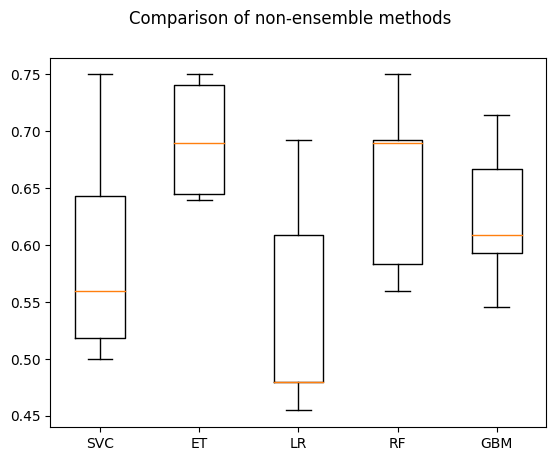

In [32]:
import re
df=pd.read_csv("drive/MyDrive/Multiomics/Dataset/Data/TMM/All_features_Microbiome_TMM_adult.csv")
df=df.T
df.columns = df.iloc[0]
# Drop the first row to make it the actual data
df = df.drop(df.index[0])
# print(df)#
df=pd.DataFrame(df)
def replace_dots_except_first(text):
    if '.' in text:
        first_part, remaining_part = text.split('.', 1)
        remaining_part_without_dots = re.sub(r'\.', '', remaining_part)
        return first_part + '.' + remaining_part_without_dots
    else:
        return text  # Return the text as is if no dot is found

# Apply the dot replacement function to each column
df = df.apply(lambda col: col.astype(str).apply(replace_dots_except_first))
# Convert DataFrame to NumPy array with float dtype

df = df.astype("float")


# Extracting rows from all_data_df where Sample_Name is in virus_samples_df
df_virus = df[df.index.isin(Samples_virus['Sample_Name'])]
# print(df_virus)

df_no_virus = df[df.index.isin(Samples_no_virus['Sample_Name'])]
# print(df_no_virus)

# print(df_virus.shape)
# print(df_no_virus.shape)

"""Create control label"""

df_virus['label'] = 1

"""Create prediabetic label"""

df_no_virus['label'] = 0

DF_all = pd.concat([df_no_virus,df_virus], axis=0)

"""Shuffeling"""

DF_all= DF_all.sample(frac=1,random_state=1)

DF_all['Sample_names']=DF_all.index

DF_all
DF_all = DF_all.fillna(0)

X = DF_all.drop(['Sample_names','label'],axis=1)
y = DF_all['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, )
results, Models = ML_Pipeline(X_train,y_train,test=True,X_test= X_test,y_test = y_test)

results_df = pd.DataFrame(results)
# results_df
results_df.to_csv("drive/MyDrive/Multiomics/Last_Results/All_features_Microbiome_adult_mean_of_ratio.csv")


Model val_mean_score val_std_score
('SVC', 0.6211858853760381, 0.022140461512165283)
test_score 0.5925925925925926
('ET', 0.5554593554593554, 0.09936561908629483)
test_score 0.5652173913043478
('LR', 0.5470094317920405, 0.10832480497316689)
test_score 0.47058823529411764
('RF', 0.5861965403018035, 0.13715917348142792)
test_score 0.5499999999999999
('GBM', 0.4848426212590299, 0.1750826250346639)
test_score 0.45


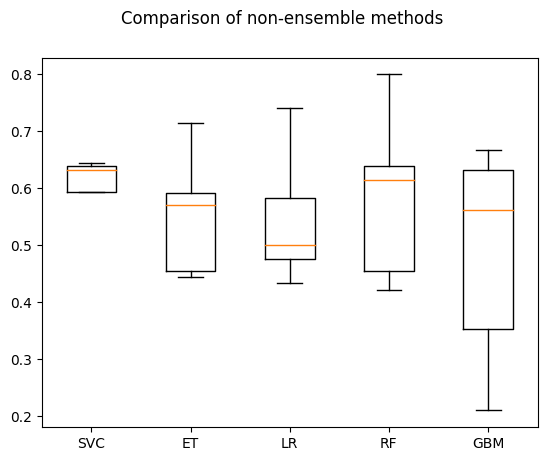

In [33]:
import re
df=pd.read_csv("drive/MyDrive/Multiomics/Dataset/Data/TMM/All_features_Microbiome_TMM_child.csv")
df=df.T
df.columns = df.iloc[0]
# Drop the first row to make it the actual data
df = df.drop(df.index[0])
# print(df)#
df=pd.DataFrame(df)
def replace_dots_except_first(text):
    if '.' in text:
        first_part, remaining_part = text.split('.', 1)
        remaining_part_without_dots = re.sub(r'\.', '', remaining_part)
        return first_part + '.' + remaining_part_without_dots
    else:
        return text  # Return the text as is if no dot is found

# Apply the dot replacement function to each column
df = df.apply(lambda col: col.astype(str).apply(replace_dots_except_first))
# Convert DataFrame to NumPy array with float dtype

df = df.astype("float")


# Extracting rows from all_data_df where Sample_Name is in virus_samples_df
df_virus = df[df.index.isin(Samples_virus['Sample_Name'])]
# print(df_virus)

df_no_virus = df[df.index.isin(Samples_no_virus['Sample_Name'])]
# print(df_no_virus)

# print(df_virus.shape)
# print(df_no_virus.shape)

"""Create control label"""

df_virus['label'] = 1

"""Create prediabetic label"""

df_no_virus['label'] = 0

DF_all = pd.concat([df_no_virus,df_virus], axis=0)

"""Shuffeling"""

DF_all= DF_all.sample(frac=1,random_state=1)

DF_all['Sample_names']=DF_all.index

DF_all
DF_all = DF_all.fillna(0)

X = DF_all.drop(['Sample_names','label'],axis=1)
y = DF_all['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, )
results, Models = ML_Pipeline(X_train,y_train,test=True,X_test= X_test,y_test = y_test)

results_df = pd.DataFrame(results)
# results_df
results_df.to_csv("drive/MyDrive/Multiomics/Last_Results/All_features_Microbiome_child_mean_of_ratio.csv")


Model val_mean_score val_std_score
('SVC', 0.927930735930736, 0.061999989723072226)
test_score 0.8780487804878049
('ET', 0.9255411255411256, 0.07485047531273066)
test_score 0.8780487804878049
('LR', 0.9120255975908151, 0.05803650584541793)
test_score 0.8780487804878049
('RF', 0.9191221532091097, 0.04576723311762971)
test_score 0.8780487804878049
('GBM', 0.8218281718281718, 0.10922081470466515)
test_score 0.8292682926829269


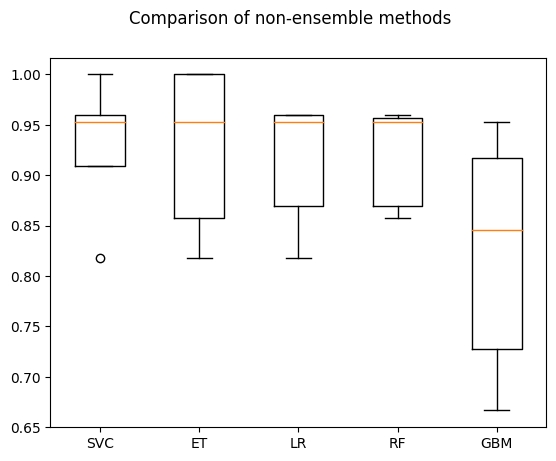

In [34]:
import re
df=pd.read_csv("drive/MyDrive/Multiomics/Dataset/Data/TMM/All_features_mRNA_TMM_adult.csv")
df=df.T
df.columns = df.iloc[0]
# Drop the first row to make it the actual data
df = df.drop(df.index[0])
# print(df)#
df=pd.DataFrame(df)
def replace_dots_except_first(text):
    if '.' in text:
        first_part, remaining_part = text.split('.', 1)
        remaining_part_without_dots = re.sub(r'\.', '', remaining_part)
        return first_part + '.' + remaining_part_without_dots
    else:
        return text  # Return the text as is if no dot is found

# Apply the dot replacement function to each column
df = df.apply(lambda col: col.astype(str).apply(replace_dots_except_first))
# Convert DataFrame to NumPy array with float dtype

df = df.astype("float")


# Extracting rows from all_data_df where Sample_Name is in virus_samples_df
df_virus = df[df.index.isin(Samples_virus['Sample_Name'])]
# print(df_virus)

df_no_virus = df[df.index.isin(Samples_no_virus['Sample_Name'])]
# print(df_no_virus)

# print(df_virus.shape)
# print(df_no_virus.shape)

"""Create control label"""

df_virus['label'] = 1

"""Create prediabetic label"""

df_no_virus['label'] = 0

DF_all = pd.concat([df_no_virus,df_virus], axis=0)

"""Shuffeling"""

DF_all= DF_all.sample(frac=1,random_state=1)

DF_all['Sample_names']=DF_all.index

DF_all
DF_all = DF_all.fillna(0)

X = DF_all.drop(['Sample_names','label'],axis=1)
y = DF_all['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, )
results, Models = ML_Pipeline(X_train,y_train,test=True,X_test= X_test,y_test = y_test)

results_df = pd.DataFrame(results)
# results_df
results_df.to_csv("drive/MyDrive/Multiomics/Last_Results/All_features_mRNA_adult_mean_of_ratio.csv")


Model val_mean_score val_std_score
('SVC', 0.9349030679465462, 0.02499880808633289)
test_score 0.9130434782608695
('ET', 0.9228571428571428, 0.038615495109930065)
test_score 0.8372093023255814
('LR', 0.9190269151138717, 0.03265702816585882)
test_score 0.9583333333333334
('RF', 0.9141991341991341, 0.035773818936822535)
test_score 0.888888888888889
('GBM', 0.8593675889328063, 0.043469923742522905)
test_score 0.8636363636363635


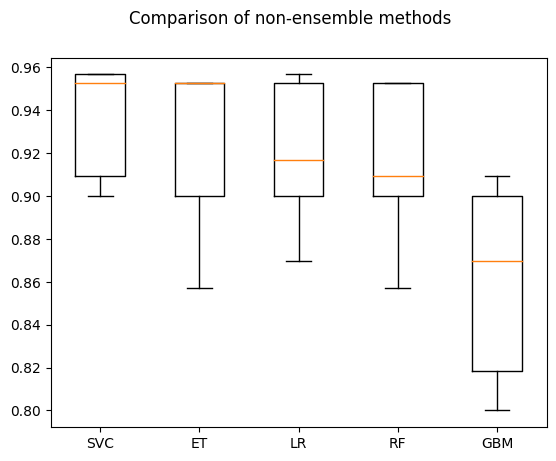

In [36]:
import re
df=pd.read_csv("drive/MyDrive/Multiomics/Dataset/Data/TMM/All_features_mRNA_TMM_child.csv")
df=df.T
df.columns = df.iloc[0]
# Drop the first row to make it the actual data
df = df.drop(df.index[0])
# print(df)#
df=pd.DataFrame(df)
def replace_dots_except_first(text):
    if '.' in text:
        first_part, remaining_part = text.split('.', 1)
        remaining_part_without_dots = re.sub(r'\.', '', remaining_part)
        return first_part + '.' + remaining_part_without_dots
    else:
        return text  # Return the text as is if no dot is found

# Apply the dot replacement function to each column
df = df.apply(lambda col: col.astype(str).apply(replace_dots_except_first))
# Convert DataFrame to NumPy array with float dtype

df = df.astype("float")


# Extracting rows from all_data_df where Sample_Name is in virus_samples_df
df_virus = df[df.index.isin(Samples_virus['Sample_Name'])]
# print(df_virus)

df_no_virus = df[df.index.isin(Samples_no_virus['Sample_Name'])]
# print(df_no_virus)

# print(df_virus.shape)
# print(df_no_virus.shape)

"""Create control label"""

df_virus['label'] = 1

"""Create prediabetic label"""

df_no_virus['label'] = 0

DF_all = pd.concat([df_no_virus,df_virus], axis=0)

"""Shuffeling"""

DF_all= DF_all.sample(frac=1,random_state=1)

DF_all['Sample_names']=DF_all.index

DF_all
DF_all = DF_all.fillna(0)

X = DF_all.drop(['Sample_names','label'],axis=1)
y = DF_all['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, )
results, Models = ML_Pipeline(X_train,y_train,test=True,X_test= X_test,y_test = y_test)

results_df = pd.DataFrame(results)
# results_df
results_df.to_csv("drive/MyDrive/Multiomics/Last_Results/All_features_mRNA_child_adult_mean_of_ratio.csv")


Model val_mean_score val_std_score
('SVC', 0.523448275862069, 0.10778054949288995)
test_score 0.5151515151515152
('ET', 0.8928102865860303, 0.03677874610128978)
test_score 0.9387755102040816
('LR', 0.4982883782883783, 0.1279070700954345)
test_score 0.5490196078431373
('RF', 0.885563909774436, 0.04358441387880203)
test_score 0.9387755102040816
('GBM', 0.8365332303089741, 0.051557466353703174)
test_score 0.8085106382978723


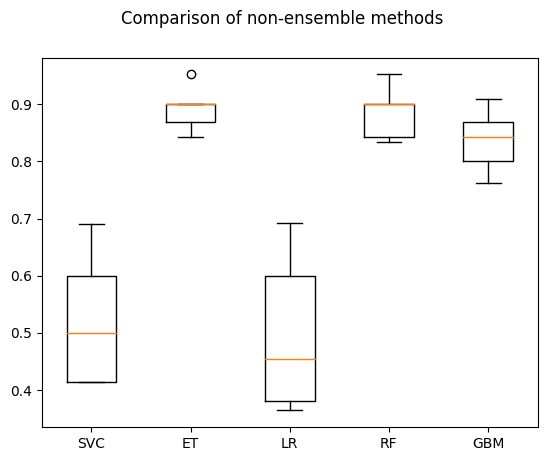

In [40]:
import re
df=pd.read_csv("drive/MyDrive/Multiomics/Dataset/Data/TMM/Adult_single_Micro_mrNA_TMM.csv")
df=df.T
df.columns = df.iloc[0]
# Drop the first row to make it the actual data
df = df.drop(df.index[0])
# print(df)#
df=pd.DataFrame(df)
def replace_dots_except_first(text):
    if '.' in text:
        first_part, remaining_part = text.split('.', 1)
        remaining_part_without_dots = re.sub(r'\.', '', remaining_part)
        return first_part + '.' + remaining_part_without_dots
    else:
        return text  # Return the text as is if no dot is found

# Apply the dot replacement function to each column
df = df.apply(lambda col: col.astype(str).apply(replace_dots_except_first))
# Convert DataFrame to NumPy array with float dtype

df = df.astype("float")


# Extracting rows from all_data_df where Sample_Name is in virus_samples_df
df_virus = df[df.index.isin(Samples_virus['Sample_Name'])]
# print(df_virus)

df_no_virus = df[df.index.isin(Samples_no_virus['Sample_Name'])]
# print(df_no_virus)

# print(df_virus.shape)
# print(df_no_virus.shape)

"""Create control label"""

df_virus['label'] = 1

"""Create prediabetic label"""

df_no_virus['label'] = 0

DF_all = pd.concat([df_no_virus,df_virus], axis=0)

"""Shuffeling"""

DF_all= DF_all.sample(frac=1,random_state=1)

DF_all['Sample_names']=DF_all.index

DF_all
DF_all = DF_all.fillna(0)

X = DF_all.drop(['Sample_names','label'],axis=1)
y = DF_all['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, )
results, Models = ML_Pipeline(X_train,y_train,test=True,X_test= X_test,y_test = y_test)

results_df = pd.DataFrame(results)
# results_df
results_df.to_csv("drive/MyDrive/Multiomics/Last_Results/Adult_single_Micro_mrNA_mean_of_ratio.csv")


Model val_mean_score val_std_score
('SVC', 0.6007910547464299, 0.04457839048591236)
test_score 0.5
('ET', 0.8846780851998244, 0.059062370188889574)
test_score 0.9600000000000001
('LR', 0.6825925925925926, 0.07017125826838545)
test_score 0.7755102040816326
('RF', 0.8956561363884019, 0.05652041307250421)
test_score 0.9583333333333334
('GBM', 0.7686429512516468, 0.048552038567590446)
test_score 0.851063829787234


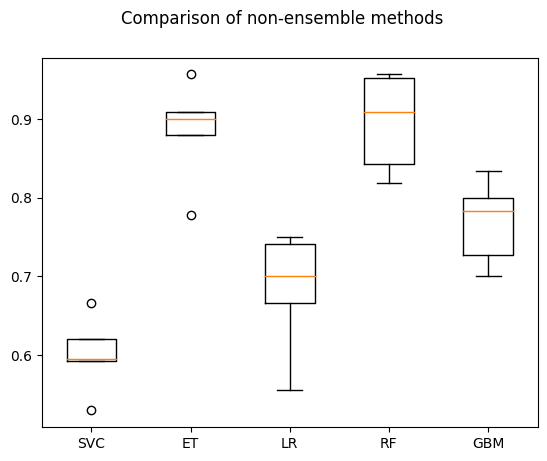

In [45]:
import re
df=pd.read_csv("drive/MyDrive/Multiomics/Dataset/Data/TMM/Child_single_Micro_mrNA_TMM.csv")
df=df.T
df.columns = df.iloc[0]
# Drop the first row to make it the actual data
df = df.drop(df.index[0])
# print(df)#
df=pd.DataFrame(df)
def replace_dots_except_first(text):
    if '.' in text:
        first_part, remaining_part = text.split('.', 1)
        remaining_part_without_dots = re.sub(r'\.', '', remaining_part)
        return first_part + '.' + remaining_part_without_dots
    else:
        return text  # Return the text as is if no dot is found

# Apply the dot replacement function to each column
df = df.apply(lambda col: col.astype(str).apply(replace_dots_except_first))
# Convert DataFrame to NumPy array with float dtype

df = df.astype("float")


# Extracting rows from all_data_df where Sample_Name is in virus_samples_df
df_virus = df[df.index.isin(Samples_virus['Sample_Name'])]
# print(df_virus)

df_no_virus = df[df.index.isin(Samples_no_virus['Sample_Name'])]
# print(df_no_virus)

# print(df_virus.shape)
# print(df_no_virus.shape)

"""Create control label"""

df_virus['label'] = 1

"""Create prediabetic label"""

df_no_virus['label'] = 0

DF_all = pd.concat([df_no_virus,df_virus], axis=0)

"""Shuffeling"""

DF_all= DF_all.sample(frac=1,random_state=1)

DF_all['Sample_names']=DF_all.index

DF_all
DF_all = DF_all.fillna(0)

X = DF_all.drop(['Sample_names','label'],axis=1)
y = DF_all['label']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, )
results, Models = ML_Pipeline(X_train,y_train,test=True,X_test= X_test,y_test = y_test)

results_df = pd.DataFrame(results)
# results_df
results_df.to_csv("drive/MyDrive/Multiomics/Last_Results/Child_single_Micro_mrNA_mean_of_ratio.csv")
